## required Libraries & packages:
os

pandas

geoppandas

rasterio: A raster dataset is a type of geospatial data structure that represents space as a grid of equally sized cells (pixels), where each cell has a value representing some information about the area it covers.

The Shapely Python module allows us to perform geometry operations in Python, without the need for RDBMSs (relational database management systems). 

OSMnx is a Python package designed for working with OpenStreetMap (OSM) data, particularly urban networks and other geospatial features.

"elevation" typically refers to working with Digital Elevation Models (DEMs) or obtaining elevation data for specific geographic coordinates.

matplotlib 

seaborn

Folium is a powerful Python library that helps you create several types of Leaflet maps. By default, Folium creates a map in a separate HTML file. Since Folium results are interactive, this library is very useful for dashboard building. You can also create inline Jupyter maps in Folium.

Pvlib, or photovoltaic library, is a community-developed toolbox designed for simulating the performance of photovoltaic (PV) energy systems.

The requests library in Python is a popular and widely used external package for making HTTP requests. It simplifies the process of interacting with web services and APIs, making it easier to send and receive data over the internet.

The pyproj is a Python package that performs cartographic transformations and geodetic computations. 

plotly 

Dash is a popular Python framework for creating interactive data visualization interfaces. With Dash, you build web applications using only Python, without needing advanced web development skills. It integrates seamlessly with technologies like Flask, React. js, and Plotly.

Streamlit is an open-source Python library that makes it easy to create and share custom web apps for machine learning and data science. By using Streamlit you can quickly build and deploy powerful data applications

scikit-learn

xgboost

## Imports

In [2]:
import pandas as pd
import requests

In [3]:
import os

In [4]:
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.mask import mask

In [5]:
import elevation

In [6]:
from rasterio.plot import show

In [7]:
import matplotlib.pyplot as plt

In [8]:
import osmnx as ox

## Solar radiation and weather data 
Source: National Renewable Energies Labaratory (NREL) National Solar Radiation DataBases (NSRDB) (API access)

Data: GHI, DNI, DHI, wind speed, temperature

Time resolution: hourly


In [9]:
os.makedirs("data/solar", exist_ok=True)

In [10]:
def fetch_nsrdb(lon, lat, year, api_key, email):
    url = f"https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?api_key={api_key}&wkt=POINT({lon}%20{lat})&names={year}&interval=60&email={email}"
    r = requests.get(url)
    filename = f"data/solar/ottawa_nsrdb_{year}.csv"
    with open(filename, "wb") as f:
        f.write(r.content)
    

api_key = "WBjf8LwUo00hXpbfhhLwecqIQeSNMLlVZ0CYwum1"
email = "simahamedifar@cmail.carleton.ca"
fetch_nsrdb(lon=-75.6972, lat=45.4215, year=2020, api_key=api_key, email = email)
# df = pd.read_csv(f"data/solar/ottawa_nsrdb_{2020}.csv")
df = pd.read_csv(f"data/solar/ottawa_nsrdb_{2020}.csv", skiprows=2)
df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2020,1,1,0,30,-0.8,0,0,0,4,...,0,98.82,120.70,0.87,990,0.8,201,0.7,0.0,0.0
1,2020,1,1,1,30,-1.5,0,0,0,4,...,0,98.48,131.20,0.87,990,0.8,207,0.6,0.0,0.0
2,2020,1,1,2,30,-2.2,0,0,0,4,...,0,97.80,141.35,0.87,990,0.8,208,0.6,0.0,0.0
3,2020,1,1,3,30,-2.8,0,0,0,4,...,0,97.12,150.34,0.87,989,0.8,210,0.6,0.0,0.0
4,2020,1,1,4,30,-3.2,0,0,0,4,...,0,95.72,156.48,0.87,989,0.8,221,0.6,0.0,0.0


In [11]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)'],
      dtype='object')

## Land Cover
The objective is to carry out resource assessment in Ottawa. 

Canada Land Cover 2015 (Natural Resources Canada)

Resolution: 30 m.

Categories: forest, cropland, urban, water, etc.

Download here.  https://open.canada.ca/data/en/dataset/3b27a8b0-0d02-4c2a-99a5-4bdfc0d56f5d


In [12]:
os.makedirs("data/land", exist_ok=True)

In [13]:
# lon=-75.6972, lat=45.4215
bbox = box(-76.5, 44.9, -75.0, 45.6) # min of lon & lat, max of lon & lat
geo = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
land = "data/land/landcover-2020-classification.tif"
with rasterio.open(land) as src:
    print("Raster CRS:", src.crs)
    geo = geo.to_crs(src.crs)
    out_img, out_transform = mask(src, geo.geometry, crop=True)
    out_meta = src.meta

print("Clipped land cover shape:", out_img.shape)

Raster CRS: EPSG:3979
Clipped land cover shape: (1, 3705, 4594)


## Digital Elevation 

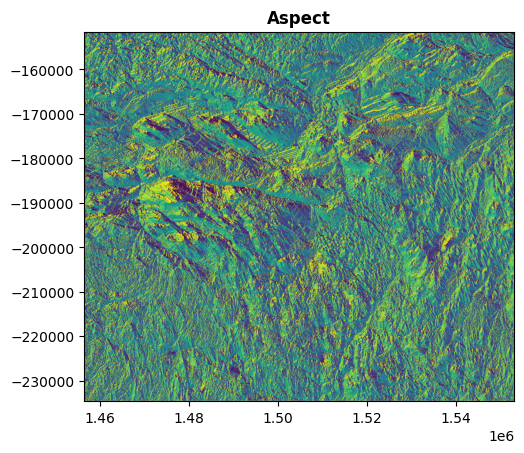

In [14]:
aspect_path = "data/land/viz/viz.be_aspect.tif"
with rasterio.open(aspect_path) as src:
    src.read(1)
    show(src, title="Aspect")

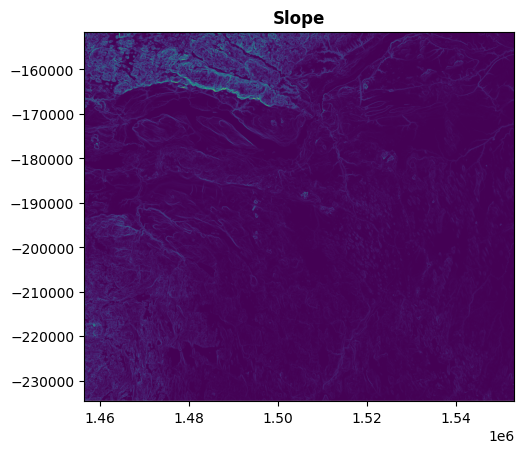

In [15]:
slope_path = "data/land/viz/viz.be_slope.tif"
with rasterio.open(slope_path) as src:
    src.read(1)
    show(src, title="Slope")

## Protected Areas
Downloaded the data from https://www.protectedplanet.net/country/CAN

In [16]:
file_path = "data/land/WDPA_WDOECM_Aug2025_Public_CAN_shp/WDPA_WDOECM_Aug2025_Public_CAN_shp_0"
protected_land_CA = gpd.read_file(file_path)
ottawa_bbox = gpd.GeoDataFrame(geometry=[box(-76.5, 44.9, -75.0, 45.5)], crs="EPSG:4326")
protected_land_CA = protected_land_CA.to_crs("EPSG:4326")
protected_land_Ottawa = gpd.overlay(protected_land_CA, ottawa_bbox, how="intersection")
print("Protected areas in Ottawa region", protected_land_Ottawa.shape)

Protected areas in Ottawa region (0, 29)


/Users/simahamedifar/Documents/VSCode/Renewable Energies/resource assessment/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'WDPA_WDOECM_Aug2025_Public_CAN_shp_0': 'WDPA_WDOECM_Aug2025_Public_CAN_shp-points' (default), 'WDPA_WDOECM_Aug2025_Public_CAN_shp-polygons'. Specify layer parameter to avoid this warning.
  result = read_func(


There are no protected areas in Ottawa. (0)

## Power Lines and Substations

In [17]:
place = "Ottawa, Ontario, Canada"
grid = ox.features_from_place(place, tags={"power":True})
lines = grid[grid["power"]=="line"]
substations = grid[grid["power"]=="substation"]
print("Power Transmission Lines:", len(lines))
print("Power Substations:", len(substations))

Power Transmission Lines: 523
Power Substations: 108


In [19]:
lines.to_file("ottawa_grid_lines.shp", driver="ESRI Shapefile")

points = substations[substations.geom_type == "Point"]
polygons = substations[substations.geom_type.isin(["Polygon", "MultiPolygon"])]

points.to_file("ottawa_substations_points.shp", driver="ESRI Shapefile")
polygons.to_file("ottawa_substations_polygons.shp", driver="ESRI Shapefile")

/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_42101/3157302818.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lines.to_file("ottawa_grid_lines.shp", driver="ESRI Shapefile")
/Users/simahamedifar/Documents/VSCode/Renewable Energies/resource assessment/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'canvec:CODE' to 'canvec_COD'
  ogr_write(
/Users/simahamedifar/Documents/VSCode/Renewable Energies/resource assessment/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'line_attachment' to 'line_attac'
  ogr_write(
/Users/simahamedifar/Documents/VSCode/Renewable Energies/resource assessment/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'generator:method' to 'generator_'
  ogr_write(
/Users/simahamedifar/Documents/VSCode/Renewable Energies/resource asses